# Demo for processing NIRSpec data from DD-2756 (PI: Pat Kelly)

In [1]:
# Are we on a GitHub codespace?
import os
if os.getcwd().startswith('/workspaces/msaexp'):
    import os
    os.environ['CRDS_PATH'] = os.path.join('/tmp/', 'crds_cache')

    if not os.path.exists(os.environ['CRDS_PATH']):
        ! mkdir {os.environ['CRDS_PATH']}

    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

    print('On codespace: ', os.environ['CRDS_PATH'], os.environ['CRDS_SERVER_URL'])

    workdir  = '/workspaces/msaexp/docs/examples/codespace'
    if not os.path.exists(workdir):
        ! mkdir {workdir}
    
    os.chdir(workdir)



On codespace:  /tmp/crds_cache https://jwst-crds.stsci.edu


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import msaexp
from msaexp import pipeline

print(f'msaexp version = {msaexp.__version__}')

msaexp version = 0.5.1


In [3]:
os.getcwd()

'/workspaces/msaexp/docs/examples/codespace'

# Query MAST for NIRSpec data

Query by program name and download `rate.fits` files with `mastquery`.  May need to set `$MAST_TOKEN` environment variable to enable the downloads from MAST.

Can optionally limit the query to specific 

 - gratings:  ``prism``, ``g140m``, ``g235m``, ``g395m``, ``g140m``, ``g235m``, ``g395m``
 - filters:  ``clear``, ``f170lp``, ``f100lp``, ``f170lp``, ``f290lp``
 - detectors: ``nrs1``, ``nrs2``
 
 

In [4]:
# Query NIRSpec data for a program name
masks = pipeline.query_program(2767, download=True, gratings=['prism'], detectors=['nrs2'])

# Initialize pipeline

Exposures are grouped by detector and with a common `MSAMETFL` metadata file for the MSA setup.

In [5]:
import glob
files = glob.glob('jw02767*rate.fits')

groups = pipeline.exposure_groups(files=files)
print('\nFiles: ')
for g in groups:
    if '2736' not in g:
        continue
        
    print (f"{g} : {' '.join(groups[g])}")

   N  value     
====  ==========
   3  jw02767005001-02-clear-prism-nrs2

Files: 


In [6]:
pipe = pipeline.NirspecPipeline(mode='jw02767005001-02-clear-prism-nrs2', source_ids=[11027, 2740], pad=1)

# (2023-02-07 16:07:08.979)
msaexp.NirspecPipeline: Initialize jw02767005001-02-clear-prism-nrs2
msaexp.NirspecPipeline: jw02767005001_03105_00002_nrs2_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00003_nrs2_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00004_nrs2_rate.fits
# (2023-02-07 16:07:09.135)
msaexp.utils.pad_msa_metafile: Trim jw02767005001_02_msa.fits to [11027, 2740]
msaexp.utils.pad_msa_metafile: pad = 1
msaexp.NirspecPipeline: mode=jw02767005001-02-clear-prism-nrs2 msametfl=src_jw02767005001_02_msa.fits


## Preprocessing pipeline

1. Run 1/f correction and identify "snowballs" on the `rate.fits` files
2. Remove "bias" (i.e., simple median) of each exposure
3. Run parts of the Level 2 JWST calibration pipeline ([calweb_spec2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html#calwebb-spec2)):
  - [AssignWcs](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.assign_wcs.AssignWcsStep.html) : initialize WCS and populate slit bounding_box data
  - [Extract2dStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.extract_2d.Extract2dStep.html) : identify slits and set slit WCS
  - [FlatFieldStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.flatfield.FlatFieldStep.html#flatfieldstep) : slit-level flat field
  - [PathLossStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pathloss.PathLossStep.html) : NIRSpec path loss
  - [PhotomStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.photom.PhotomStep.html) : Photometric calibration
  
  Note that the `srctype`, `master_background`, `wavecorr` steps are not performed.  The background subtraction is done manually on the 2D slit cutouts.
  
4. Parse slit metadata
5. Save slit cutout files of the last pipeline step performed (`phot` = `PhotomStep`)

Subsequent re-initialization of the `NirspecPipeline` object and `full_pipeline` method will skip these steps and just load the saved slit cutouts.

In [7]:
# Run the pipeline to define slits, etc., but don't do extractions yet.  
if not os.path.exists(f'{pipe.mode}.slits.yaml'):
    pipe.full_pipeline(run_extractions=False, initialize_bkg=False)
else:
    print('Skip preprocessing')

Skip preprocessing


In [8]:
import glob
files = glob.glob(f'{pipe.mode}*')
files.sort()
for f in files:
    print(f)

jw02767005001-02-clear-prism-nrs2.log.txt
jw02767005001-02-clear-prism-nrs2.reg
jw02767005001-02-clear-prism-nrs2.slits.yaml


In [9]:
# Parse slit polygons
# try to use the slitlet WCS to generate a polygon in sky coordinates of the slit locations
# if not os.path.exists('jw02767005001-02-clear-prism-nrs2.slits.reg'):
#    pipe.get_slit_polygons()

## Pipeline products

In [10]:
print('Pipeline entries: ', list(pipe.pipe.keys()))
print('Last step: ', pipe.last_step)

Pipeline entries:  []
Last step:  None


# Reinitialize with limited set of targets

In [11]:
targets = ['2767_11027', # z=9.5 galaxy from Williams et al.
           '2767_2740', # z=1.14
          ]

pipe = pipeline.NirspecPipeline(mode='jw02767005001-02-clear-prism-nrs2')
pipe.full_pipeline(run_extractions=False, targets=targets)

# (2023-02-07 16:07:09.675)
msaexp.NirspecPipeline: Initialize jw02767005001-02-clear-prism-nrs2
msaexp.NirspecPipeline: jw02767005001_03105_00002_nrs2_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00003_nrs2_rate.fits
msaexp.NirspecPipeline: jw02767005001_03105_00004_nrs2_rate.fits
msaexp.NirspecPipeline: mode=jw02767005001-02-clear-prism-nrs2 msametfl=jw02767005001_02_msa.fits
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.000.2767_2740.fits 2767_2740
msaexp.read_data: jw02767005001_03105_00002_nrs2_phot.001.2767_11027.fits 2767_11027
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.000.2767_2740.fits 2767_2740
msaexp.read_data: jw02767005001_03105_00003_nrs2_phot.001.2767_11027.fits 2767_11027
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.000.2767_2740.fits 2767_2740
msaexp.read_data: jw02767005001_03105_00004_nrs2_phot.001.2767_11027.fits 2767_11027
# slit_index slitlet_id  source_name  source_ra  source_dec
# jw02767005001-02-clear-prism-nrs2
# Get slit

## Slitlet metadata

In [12]:
pipe.targets

['2767_2740', '2767_11027']

# Extract spectra

yoffset : offset in pixels relative to where the slit WCS thinks the target coordinates should be
prof_sigma : gaussian profile sigma width
skip : list of indices to exclude from the combination to avoid bad pixels, misalignment, etc.

Failed to `import dust_attenuation`
Install my fork with $ pip install git+https://github.com/gbrammer/dust_attenuation.git
Failed to `import dust_extinction`
Install my fork with $ pip install git+https://github.com/gbrammer/dust_extinction.git


2023-02-07 16:07:17,810 - stpipe - WARNING - /home/codespace/.python/current/lib/python3.10/site-packages/msaexp/pipeline.py:1239: RuntimeWarning: All-NaN slice encountered
  pscl = np.nanmax(_running[1])



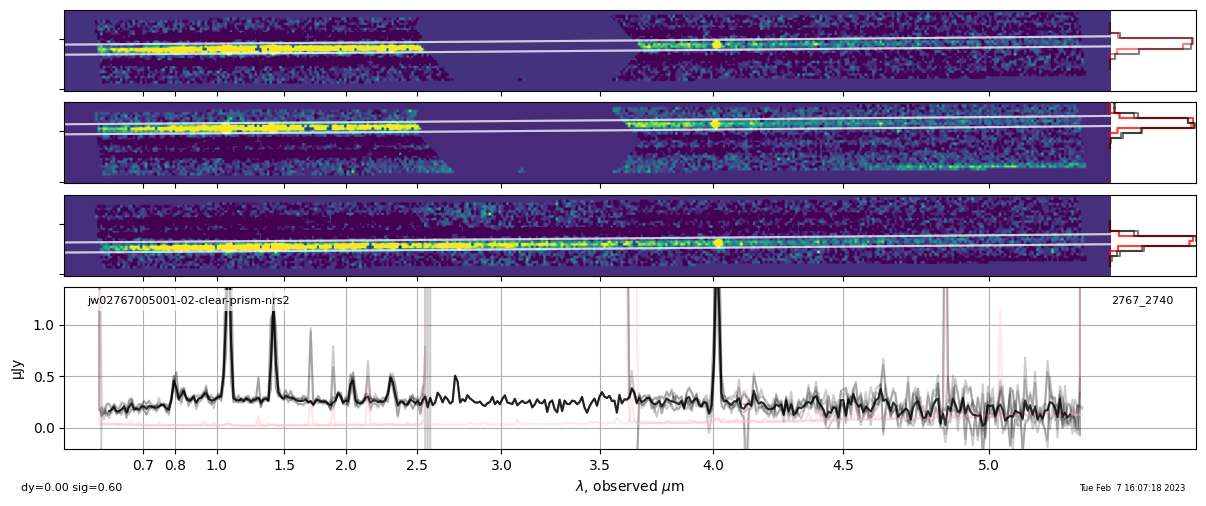

In [13]:
key = '2767_11027' # z=9.5 galaxy from Williams et al.
key = '2767_2740' # z=1.14 with lines

_ = pipe.extract_spectrum(key, skip=[], yoffset=0, prof_sigma=0.6, trace_sign=-1, fit_profile_params=None)

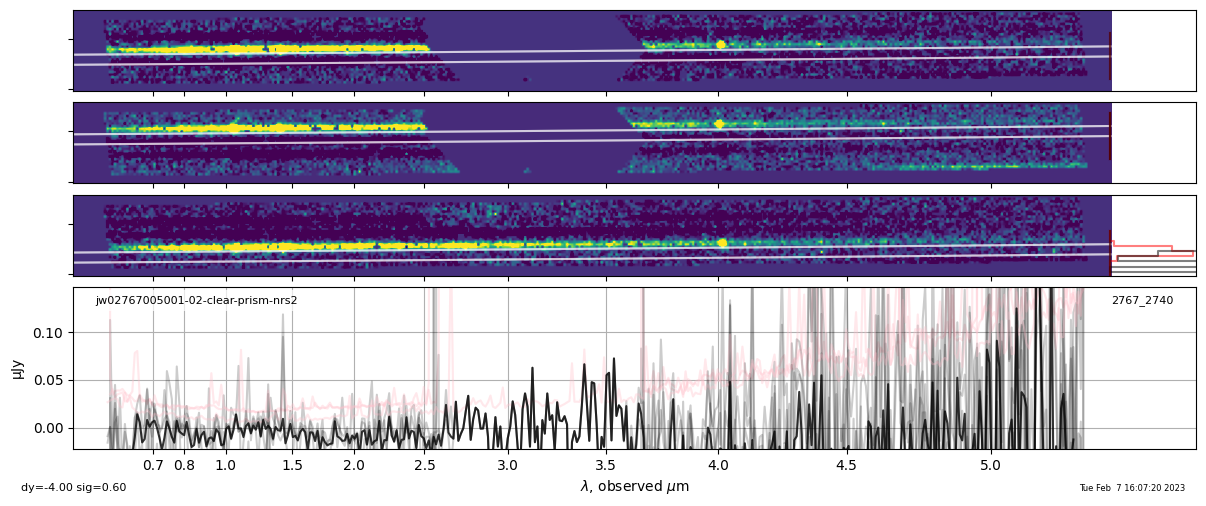

In [14]:
# Shift the extraction along the slit (bad here)
_ = pipe.extract_spectrum(key, skip=[], yoffset=-4, prof_sigma=0.6, trace_sign=-1, fit_profile_params=None)

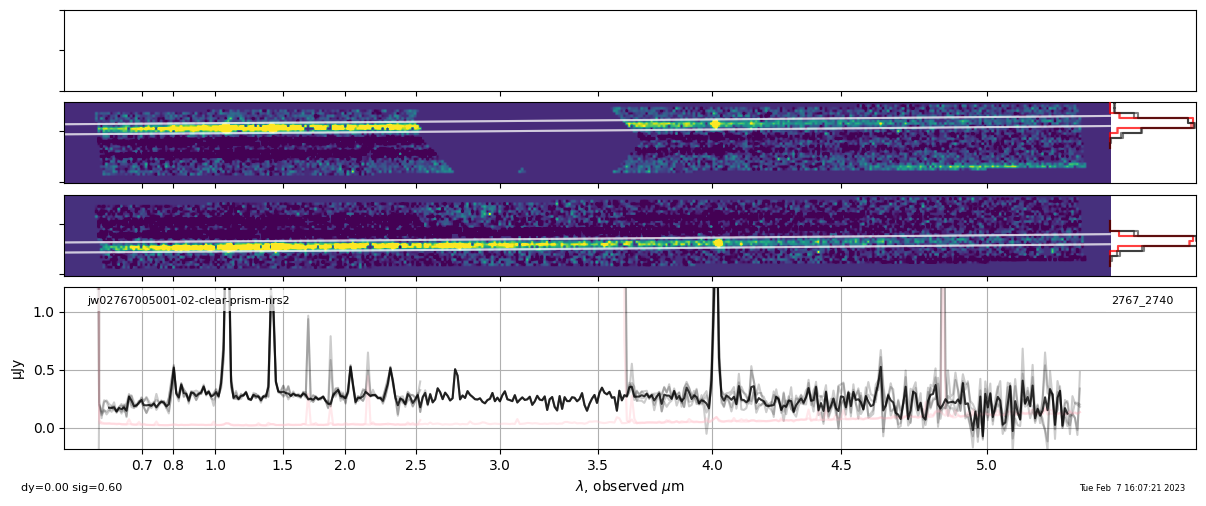

In [15]:
# Exclude first exposure
_ = pipe.extract_spectrum(key, skip=[0], yoffset=0, prof_sigma=0.6, trace_sign=-1, fit_profile_params=None)

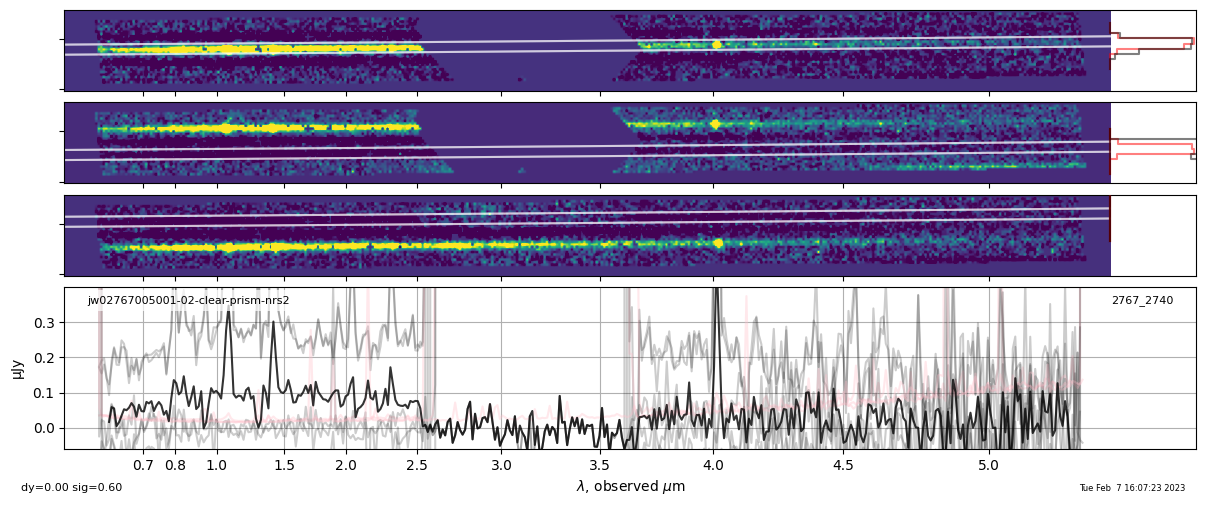

In [16]:
# Not quite sure why the sign flips
# maybe sign=-1 for prism, +1 otherwise?
_ = pipe.extract_spectrum(key, skip=[], yoffset=0, prof_sigma=0.6, trace_sign=1, fit_profile_params=None)

2023-02-07 16:07:24,413 - stpipe - WARNING - /home/codespace/.python/current/lib/python3.10/site-packages/msaexp/pipeline.py:911: OptimizeWarning: Unknown solver options: direc
  _res = minimize(_objfun_fit_profile, x0,



msaexp.fit_profile:      2767_2740             (dchi2 =   5517.6) yoffset = -0.13  prof_sigma = 0.63 dchi2 =    311.0


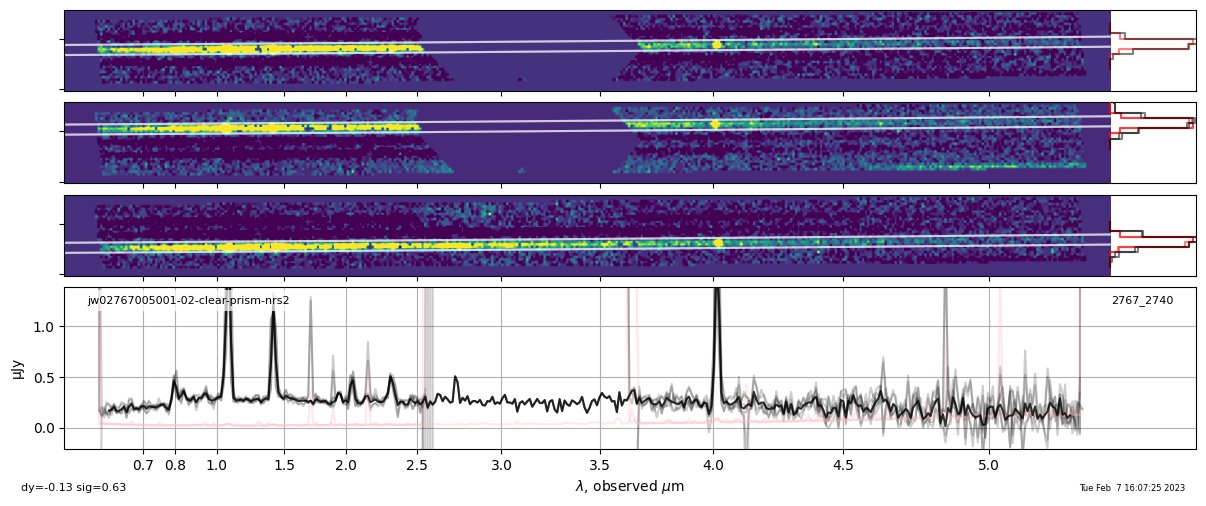

In [17]:
# Fit optimal profile
_data = pipe.extract_spectrum(key, skip=[], yoffset=0, prof_sigma=0.6, trace_sign=-1, 
                              fit_profile_params={'min_delta':20})
slitlet, sep1d, opt1d, fig = _data

## Drizzled 2D spectrum

In [18]:
# Get background-subtracted slitlets
slits = pipe.get_background_slits(key, step='bkg', check_background=True)
len(slits)

3

In [19]:
import msaexp.utils

drizzle_params = dict(output=None,
                      single=True,
                      blendheaders=True,
                      pixfrac=0.5,
                      kernel='square',
                      fillval=0,
                      wht_type='ivm',
                      good_bits=0,
                      pscale_ratio=1.0,
                      pscale=None)

# Drizzle each exposure
kwargs = {'keep_wave':1}
wave, header, results = msaexp.utils.drizzle_slits_2d(slits, drizzle_params=drizzle_params, **kwargs)


build_regular_wavelength_wcs: Set linear wave grid (dlam=103.2 Ang)
Pad 2 pixels on 2D cutout


2023-02-07 16:07:27,950 - stpipe - INFO - Driz parameter kernal: square
2023-02-07 16:07:27,951 - stpipe - INFO - Driz parameter pixfrac: 0.5
2023-02-07 16:07:27,951 - stpipe - INFO - Driz parameter fillval: 0
2023-02-07 16:07:27,952 - stpipe - INFO - Driz parameter weight_type: ivm
2023-02-07 16:07:28,293 - stpipe - INFO - Blending metadata for None
2023-02-07 16:07:29,666 - stpipe - INFO - Resampling science data
2023-02-07 16:07:29,729 - stpipe - INFO - Drizzling (32, 421) --> (42, 421)
2023-02-07 16:07:29,733 - stpipe - INFO - Resampling var_rnoise
2023-02-07 16:07:29,810 - stpipe - INFO - Drizzling (32, 421) --> (42, 421)
2023-02-07 16:07:29,816 - stpipe - INFO - Resampling var_poisson
2023-02-07 16:07:29,878 - stpipe - INFO - Drizzling (32, 421) --> (42, 421)
2023-02-07 16:07:29,883 - stpipe - INFO - Resampling var_flat
2023-02-07 16:07:29,941 - stpipe - INFO - Drizzling (32, 421) --> (42, 421)
2023-02-07 16:07:30,161 - stpipe - INFO - Blending metadata for None
2023-02-07 16:07:

In [20]:
# Combine drizzled products with outlier rejection
prf_kwargs = {'prf_center':None, 'prf_sigma':0.6, 'fit_prf':True}
sci2d, wht2d, p2d, spec, prof = msaexp.utils.combine_2d_with_rejection(results,
                                                                       outlier_threshold=20,
                                                                       **prf_kwargs)

2023-02-07 16:07:34,275 - stpipe - WARNING - /home/codespace/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Set prf_center: 1.0 (42, 421) 11
fit_prf: center = 0.99. sigma = 0.81


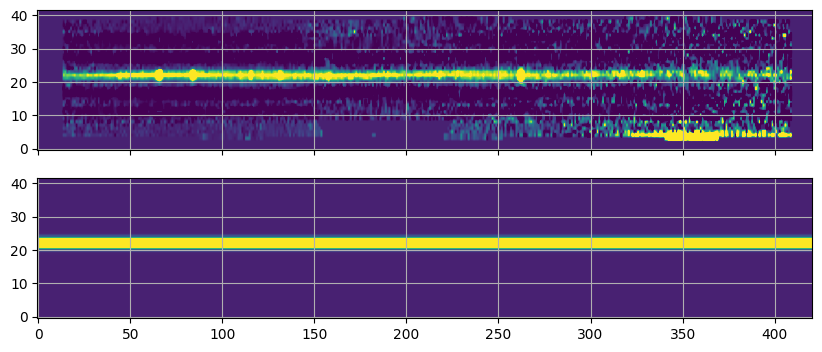

In [21]:
fig, axes = plt.subplots(2,1,figsize=(10,4), sharex=True)
axes[0].imshow(sci2d, vmin=-0.01, vmax=0.1, origin='lower', aspect='auto')
axes[1].imshow(p2d, vmin=-0.01, vmax=0.1, origin='lower', aspect='auto')
for ax in axes:
    ax.grid()

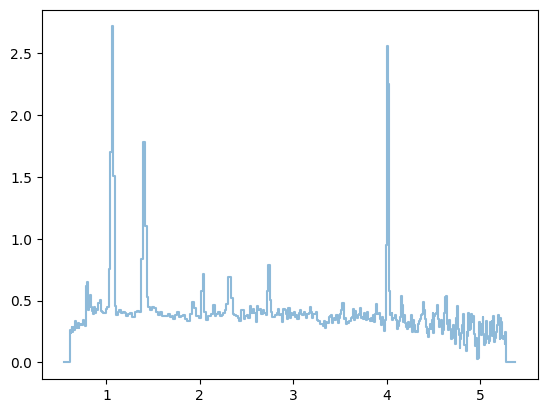

In [22]:
plt.step(spec['wave'], spec['flux'], alpha=0.5)

In [23]:
# Drizzle to a grid that oversamples the wavelengths by x2
kwargs = {'keep_wave':2}
wave2, header2, results2 = msaexp.utils.drizzle_slits_2d(slits, drizzle_params=drizzle_params, **kwargs)

build_regular_wavelength_wcs: Oversample original wavelength grid x 2
Pad 2 pixels on 2D cutout


2023-02-07 16:07:36,424 - stpipe - INFO - Driz parameter kernal: square
2023-02-07 16:07:36,425 - stpipe - INFO - Driz parameter pixfrac: 0.5
2023-02-07 16:07:36,426 - stpipe - INFO - Driz parameter fillval: 0
2023-02-07 16:07:36,426 - stpipe - INFO - Driz parameter weight_type: ivm
2023-02-07 16:07:36,784 - stpipe - INFO - Blending metadata for None
2023-02-07 16:07:38,092 - stpipe - INFO - Resampling science data
2023-02-07 16:07:38,190 - stpipe - INFO - Drizzling (32, 421) --> (42, 841)
2023-02-07 16:07:38,195 - stpipe - INFO - Resampling var_rnoise
2023-02-07 16:07:38,300 - stpipe - INFO - Drizzling (32, 421) --> (42, 841)
2023-02-07 16:07:38,310 - stpipe - INFO - Resampling var_poisson
2023-02-07 16:07:38,371 - stpipe - INFO - Drizzling (32, 421) --> (42, 841)
2023-02-07 16:07:38,377 - stpipe - INFO - Resampling var_flat
2023-02-07 16:07:38,438 - stpipe - INFO - Drizzling (32, 421) --> (42, 841)
2023-02-07 16:07:38,667 - stpipe - INFO - Blending metadata for None
2023-02-07 16:07:

In [24]:
prf_kwargs = {'prf_center':None, 'prf_sigma':0.6, 'fit_prf':True}
sci2d2, wht2d2, p2d2, spec2, prof = msaexp.utils.combine_2d_with_rejection(results2, sigma=5, **prf_kwargs)

2023-02-07 16:07:42,910 - stpipe - WARNING - /home/codespace/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,



Set prf_center: 1.0 (42, 841) 11
fit_prf: center = 0.98. sigma = 0.84


(3.9, 4.1)

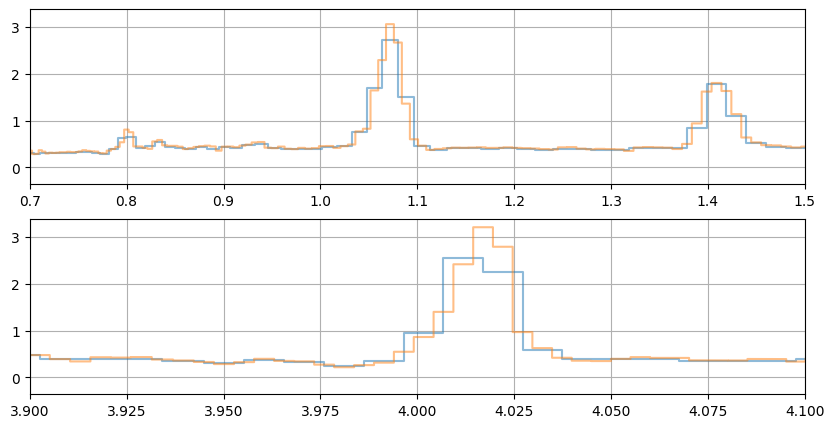

In [25]:
fig, axes = plt.subplots(2,1, figsize=(10, 5))
for ax in axes:
    ax.step(spec['wave'], spec['flux'], alpha=0.5, where='mid')
    ax.step(spec2['wave'], spec2['flux'], alpha=0.5, where='mid')
    ax.grid()

axes[0].set_xlim(0.7, 1.5)
axes[1].set_xlim(3.9, 4.1)

# 2D drizzle helper

`msaexp.utils.drizzle_2d_pipeline` does the 2D drizzle steps above and wraps the output into a FITS HDU

In [26]:
from importlib import reload
reload(msaexp.utils)

import grizli.utils
grizli.utils.set_warnings()

DRIZZLE_PARAMS = dict(output=None,
                      single=True,
                      blendheaders=True,
                      pixfrac=0.6,
                      kernel='square',
                      fillval=0,
                      wht_type='ivm',
                      good_bits=0,
                      pscale_ratio=1.0,
                      pscale=None)

slits = pipe.get_background_slits(key, step='bkg', check_background=True)

hdul = msaexp.utils.drizzle_2d_pipeline(slits, drizzle_params=DRIZZLE_PARAMS,
                                        fit_prf=True,
                                        outlier_threshold=5,
                                        prf_center=None, prf_sigma=0.6, center_limit=4, 
                                        standard_waves=1)

build_regular_wavelength_wcs: Set user-defined wavelength grid (size=414)
Pad 2 pixels on 2D cutout


2023-02-07 16:07:44,433 - stpipe - INFO - Driz parameter kernal: square
2023-02-07 16:07:44,434 - stpipe - INFO - Driz parameter pixfrac: 0.6
2023-02-07 16:07:44,435 - stpipe - INFO - Driz parameter fillval: 0
2023-02-07 16:07:44,436 - stpipe - INFO - Driz parameter weight_type: ivm
2023-02-07 16:07:44,778 - stpipe - INFO - Blending metadata for None
2023-02-07 16:07:46,503 - stpipe - INFO - Resampling science data
2023-02-07 16:07:46,566 - stpipe - INFO - Drizzling (32, 421) --> (42, 414)
2023-02-07 16:07:46,570 - stpipe - INFO - Resampling var_rnoise
2023-02-07 16:07:46,629 - stpipe - INFO - Drizzling (32, 421) --> (42, 414)
2023-02-07 16:07:46,635 - stpipe - INFO - Resampling var_poisson
2023-02-07 16:07:46,694 - stpipe - INFO - Drizzling (32, 421) --> (42, 414)
2023-02-07 16:07:46,700 - stpipe - INFO - Resampling var_flat
2023-02-07 16:07:46,761 - stpipe - INFO - Drizzling (32, 421) --> (42, 414)
2023-02-07 16:07:46,997 - stpipe - INFO - Blending metadata for None
2023-02-07 16:07:

Set prf_center: 1.0 (42, 414) 11
fit_prf: center = 0.98. sigma = 0.82


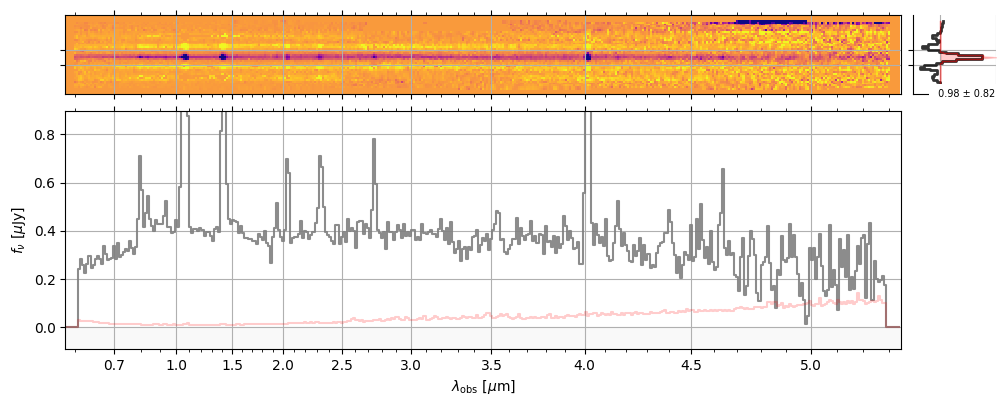

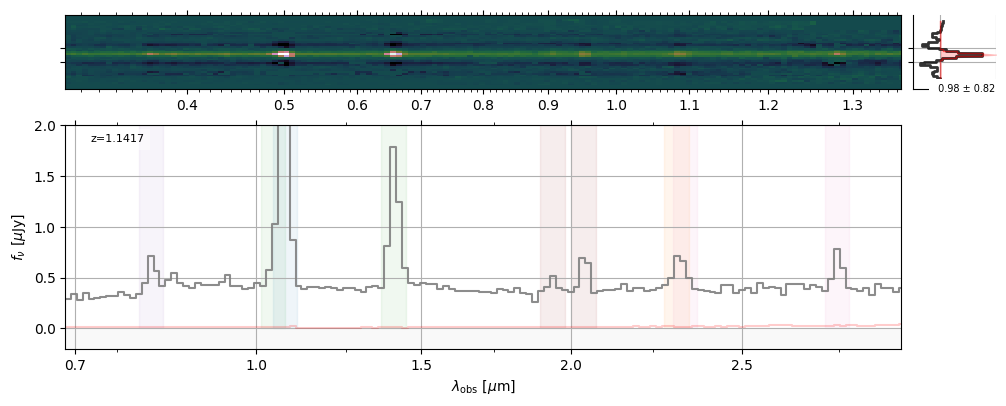

In [27]:
# Make figures showing 2D / 1D spectra
_fig = msaexp.utils.drizzled_hdu_figure(hdul, xlim=None)

# Other plot options
_fig = msaexp.utils.drizzled_hdu_figure(hdul, xlim=(0.69, 2.9), # zoom on wavelength range
                                        tick_steps=[0.5, 0.25], # major, minor
                                        ymax=2,   # y extent of plot and 2D scaling
                                        z=1.1417, # indicate strong lines for a given redshift
                                        cmap='cubehelix')


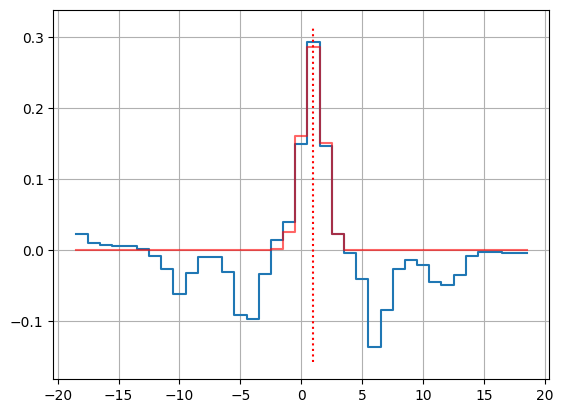

In [28]:
# Show the optimal extraction profile

plt.step(prof['pix'], prof['profile'], where='mid', label='Profile data')
plt.step(prof['pix'], prof['pfit'], where='mid', label='Profile data', color='r', alpha=0.6)

plt.vlines(prof.meta['PROFCEN'][0], *plt.ylim(), color='r', linestyle=':')
plt.grid()

# z=9.5 source from Williams et al.

3

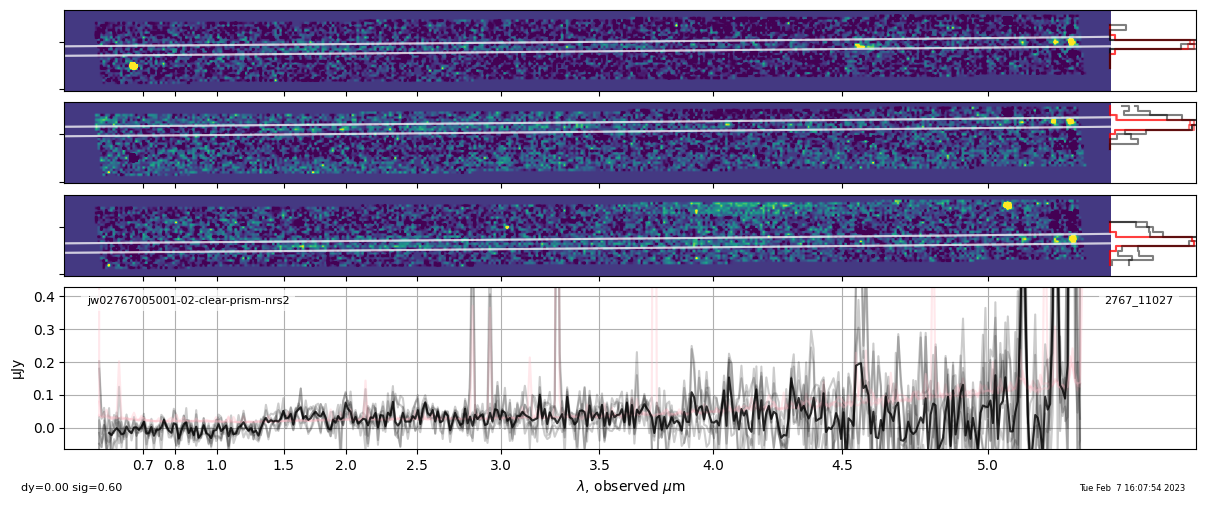

In [29]:
key = '2767_11027'
_ = pipe.extract_spectrum(key, skip=[], yoffset=0, prof_sigma=0.6, trace_sign=-1, fit_profile_params=None)

slits = pipe.get_background_slits(key, step='bkg', check_background=True)
len(slits)

In [30]:
hdul = msaexp.utils.drizzle_2d_pipeline(slits, drizzle_params=DRIZZLE_PARAMS,
                                        fit_prf=True,
                                        outlier_threshold=5,
                                        prf_center=None, prf_sigma=0.6, center_limit=4, 
                                        standard_waves=1,
                                       **kwargs
                                       )


2023-02-07 16:07:55,374 - stpipe - WARNING - UnitsWarning: 'MICRONS' did not parse as fits unit: At col 0, Unit 'MICRONS' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
2023-02-07 16:07:55,381 - stpipe - WARNING - UnitsWarning: 'MICRONS/PIXEL' did not parse as fits unit: At col 0, Unit 'MICRONS' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
2023-02-07 16:07:55,386 - stpipe - WARNING - UnitsWarning: 'RESOLUTION' did not parse as fits unit: At col 0, Unit 'RESOLUTION' not supported by the FITS standard.  If this is me

build_regular_wavelength_wcs: Set user-defined wavelength grid (size=414)
Pad 2 pixels on 2D cutout


2023-02-07 16:07:56,589 - stpipe - INFO - Driz parameter kernal: square
2023-02-07 16:07:56,590 - stpipe - INFO - Driz parameter pixfrac: 0.6
2023-02-07 16:07:56,590 - stpipe - INFO - Driz parameter fillval: 0
2023-02-07 16:07:56,591 - stpipe - INFO - Driz parameter weight_type: ivm
2023-02-07 16:07:56,930 - stpipe - INFO - Blending metadata for None
2023-02-07 16:07:58,262 - stpipe - INFO - Resampling science data
2023-02-07 16:07:58,327 - stpipe - INFO - Drizzling (34, 421) --> (42, 414)
2023-02-07 16:07:58,331 - stpipe - INFO - Resampling var_rnoise
2023-02-07 16:07:58,393 - stpipe - INFO - Drizzling (34, 421) --> (42, 414)
2023-02-07 16:07:58,399 - stpipe - INFO - Resampling var_poisson
2023-02-07 16:07:58,466 - stpipe - INFO - Drizzling (34, 421) --> (42, 414)
2023-02-07 16:07:58,473 - stpipe - INFO - Resampling var_flat
2023-02-07 16:07:58,537 - stpipe - INFO - Drizzling (34, 421) --> (42, 414)
2023-02-07 16:07:58,765 - stpipe - INFO - Blending metadata for None
2023-02-07 16:08:

Set prf_center: 1.0 (42, 414) 16
fit_prf: center = 1.05. sigma = 1.46


In [31]:
# Drizzle combinations
key = '2767_11027'

# key = targets[-1]

slits = pipe.get_background_slits(key)
output_root = f'rxj2129-prism-{key}'

scale = 1.0

DRIZZLE_PARAMS = dict(output=None,
                      single=True,
                      blendheaders=True,
                      pixfrac=1.0,
                      kernel='square',
                      fillval=0,
                      wht_type='ivm',
                      good_bits=0,
                      pscale_ratio=1.0,
                      pscale=None)

hdul = msaexp.utils.drizzle_2d_pipeline(slits, drizzle_params=DRIZZLE_PARAMS,
                                    #profile_slice=slice(int(200*scale), int(900*scale)),
                                    #standard_waves=True,
                                        keep_wave=True,
                                    outlier_threshold=10,
                                    output_root=output_root,
                                    fit_prf=True, prf_center=None, prf_sigma=0.95, fix_sigma=False)


2023-02-07 16:08:03,062 - stpipe - WARNING - UnitsWarning: 'MICRONS' did not parse as fits unit: At col 0, Unit 'MICRONS' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
2023-02-07 16:08:03,068 - stpipe - WARNING - UnitsWarning: 'MICRONS/PIXEL' did not parse as fits unit: At col 0, Unit 'MICRONS' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
2023-02-07 16:08:03,073 - stpipe - WARNING - UnitsWarning: 'RESOLUTION' did not parse as fits unit: At col 0, Unit 'RESOLUTION' not supported by the FITS standard.  If this is me

build_regular_wavelength_wcs: Set user-defined wavelength grid (size=414)
Pad 2 pixels on 2D cutout


2023-02-07 16:08:03,760 - stpipe - INFO - Driz parameter kernal: square
2023-02-07 16:08:03,761 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-02-07 16:08:03,761 - stpipe - INFO - Driz parameter fillval: 0
2023-02-07 16:08:03,762 - stpipe - INFO - Driz parameter weight_type: ivm
2023-02-07 16:08:04,124 - stpipe - INFO - Blending metadata for None
2023-02-07 16:08:05,498 - stpipe - INFO - Resampling science data
2023-02-07 16:08:05,581 - stpipe - INFO - Drizzling (34, 421) --> (42, 414)
2023-02-07 16:08:05,588 - stpipe - INFO - Resampling var_rnoise
2023-02-07 16:08:05,685 - stpipe - INFO - Drizzling (34, 421) --> (42, 414)
2023-02-07 16:08:05,691 - stpipe - INFO - Resampling var_poisson
2023-02-07 16:08:05,751 - stpipe - INFO - Drizzling (34, 421) --> (42, 414)
2023-02-07 16:08:05,760 - stpipe - INFO - Resampling var_flat
2023-02-07 16:08:05,826 - stpipe - INFO - Drizzling (34, 421) --> (42, 414)
2023-02-07 16:08:06,462 - stpipe - INFO - Blending metadata for None
2023-02-07 16:08:

Set prf_center: 2.0 (42, 414) 18
fit_prf: center = 1.21. sigma = 2.00


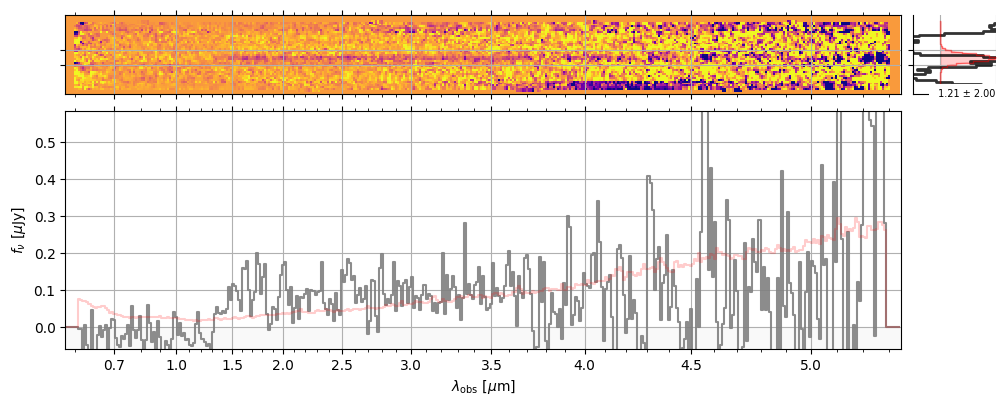

In [32]:
import astropy.units as u
_fig = msaexp.utils.drizzled_hdu_figure(hdul, xlim=None, unit='fnu')

## Fit redshift

In [33]:
import eazy
reload(eazy)

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs()
    
otempl = eazy.templates.read_templates_file('templates/sfhz/blue_sfhz_13.param')[:]

templ = [otempl[i].smooth_velocity(3.e5/250, in_place=False, smoothspec_kwargs={'fftsmooth': False}) 
         for i in [-1]]


2023-02-07 16:08:11,128 - stpipe - WARNING - /home/codespace/.python/current/lib/python3.10/site-packages/eazy/templates.py:356: ResourceWarning: unclosed file <_io.TextIOWrapper name='templates/sfhz/blue_sfhz_13.param' mode='r' encoding='UTF-8'>
  lines = open(templates_file).readlines()



Failed to `import dust_attenuation`
Install my fork with $ pip install git+https://github.com/gbrammer/dust_attenuation.git
Failed to `import dust_extinction`
Install my fork with $ pip install git+https://github.com/gbrammer/dust_extinction.git


201it [00:04, 44.92it/s]
34it [00:00, 47.60it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# rxj2129-prism-2767_11027.spec.fits
# z = 9.50984
# Tue Feb  7 16:08:19 2023
             line Hb      277.2 ±     43.9
             line Hg      217.7 ±     40.3
             line Hd      123.1 ±     40.8
             line H8       -1.1 ±     37.8
             line H9       51.5 ±     37.4
            line H10       26.1 ±     37.3
            line H11        7.2 ±     38.4
            line H12      -21.3 ±     36.1
     line NeIII-3968       67.5 ±     45.2
      line OIII-4959      548.4 ±     38.2
      line OIII-5007     1564.5 ±     49.7
      line OIII-4363       76.3 ±     41.4
            line OII      108.4 ±     37.7
      line HeII-4687        2.8 ±     36.8
     line NeIII-3867      103.8 ±     38.1
      line HeII-1640     -113.7 ±    108.9
       line CIV-1549      537.2 ±    109.9
      line CIII-1908      329.7 ±     90.1
      line OIII-1663      531.9 ±    111.6
      line NIII-1750       34.9 ±     99.7
            line Ly

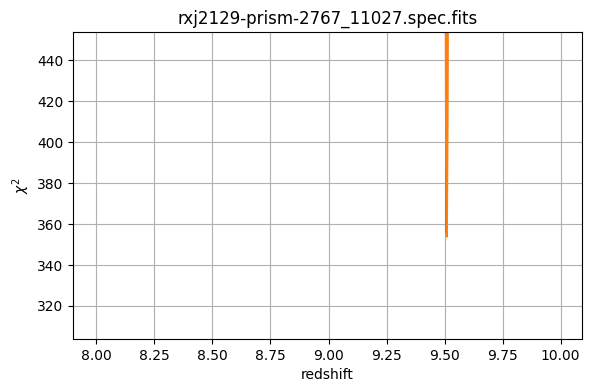

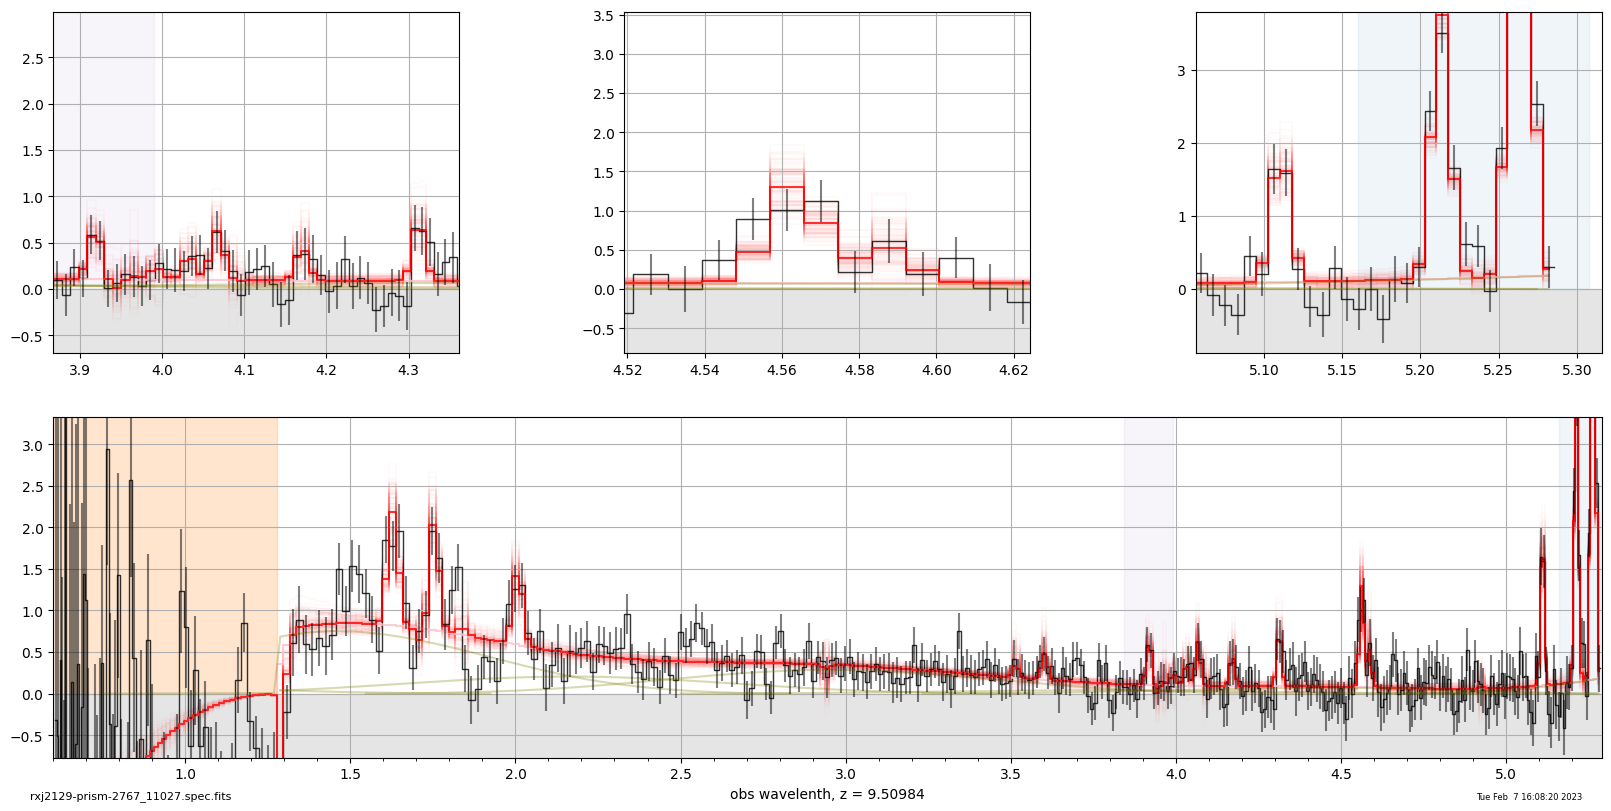

In [34]:
from msaexp import spectrum
#spectrum.SCALE_UNCERTAINTY = 1

spectrum.FFTSMOOTH = False

fig, sp, data = spectrum.fit_redshift(file=f'{output_root}.spec.fits',
                          z0=[8.,10], 
                          zstep=[0.001,0.0003],
                          eazy_templates=None,
                          nspline=9,
                          scale_disp=1.3,
                          vel_width=50.,
                          Rline=2000,
                          is_prism=True,
                          use_full_dispersion=False,
                          ranges=[(3680, 4150), (4300, 4400), (4861-50, 5008+50)],
                         )


Set SCALE_UNCERTAINTY:  [-0.01509075  0.20953423 -0.97833214  1.67691922 -0.80354896]

# line flux err
# flux x 10^-20 erg/s/cm2
# rxj2129-prism-2767_11027.spec.fits
# z = 9.50984
# Tue Feb  7 16:08:24 2023
             line Hb      318.9 ±     36.2
             line Hg      233.6 ±     30.4
             line Hd      125.5 ±     28.2
             line H8      -19.5 ±     27.8
             line H9       29.4 ±     29.3
            line H10       16.2 ±     27.9
            line H11        7.8 ±     27.0
            line H12      -13.6 ±     25.1
     line NeIII-3968       76.5 ±     30.7
      line OIII-4959      529.4 ±     32.8
      line OIII-5007     1514.6 ±     42.1
      line OIII-4363       86.9 ±     30.9
            line OII      125.1 ±     27.2
      line HeII-4687       -4.7 ±     28.7
     line NeIII-3867       81.5 ±     28.8
      line HeII-1640     -130.4 ±    167.8
       line CIV-1549      417.2 ±    170.1
      line CIII-1908      432.0 ±    127.2
      line OIII-166

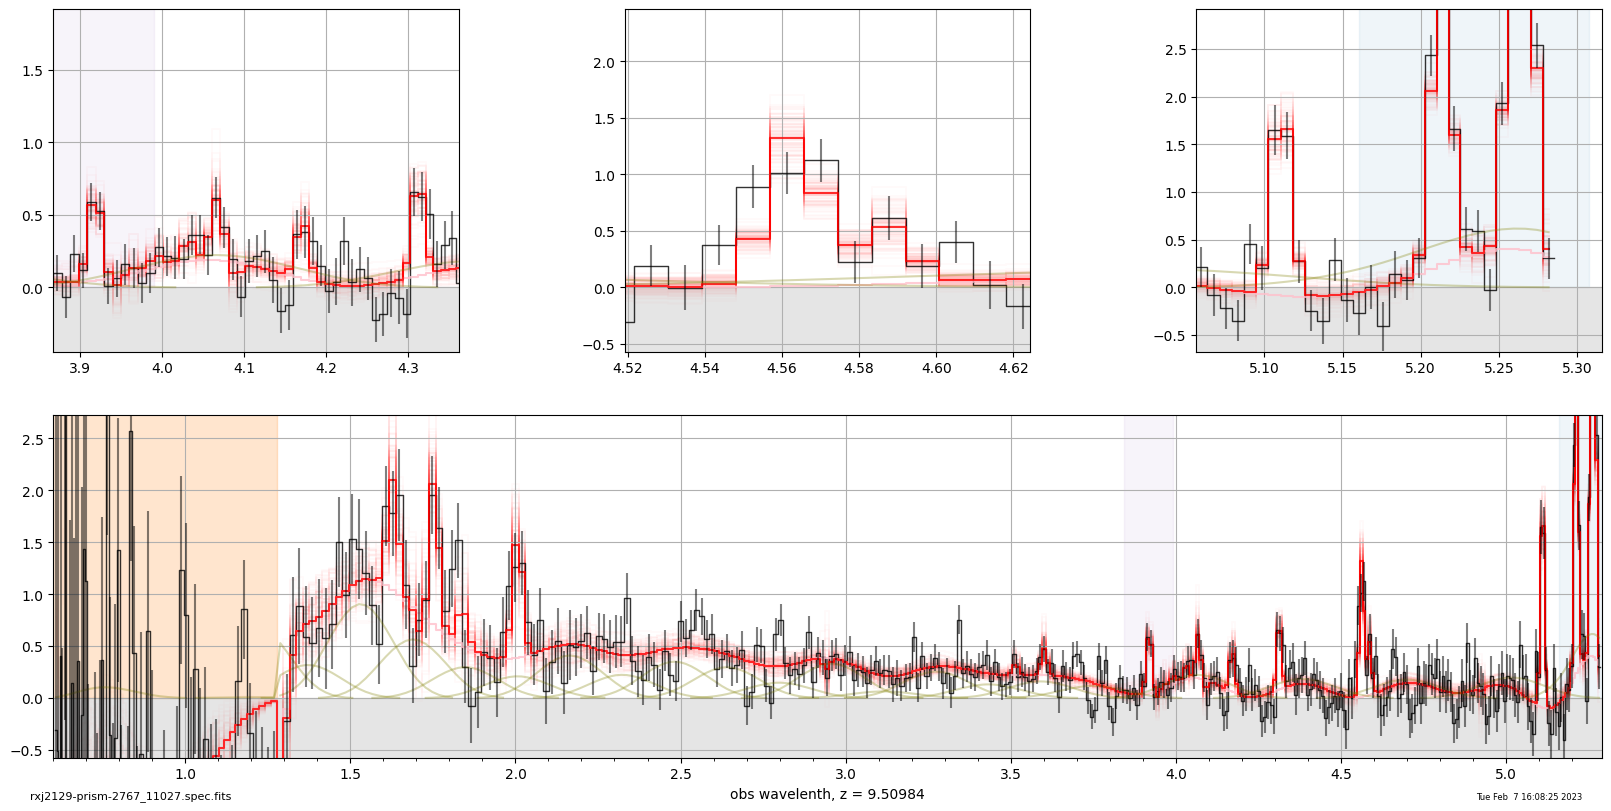

In [35]:
# Rescale uncertainties by a polynomial 
spectrum.SCALE_UNCERTAINTY = 1.0

fig, sp_scale, data = spectrum.plot_spectrum(file=f'{output_root}.spec.fits', 
                           z=data['z'],
                          eazy_templates=None,
                          nspline=33, 
                           # plot_unit=u.microJansky,
                          scale_disp=1.3,
                          vel_width=50.,
                          is_prism=True, bkg=0,
                           scale_uncertainty_kwargs={'order':4, 'init':[1,3]},
                           use_full_dispersion=True,
                           Rline=2000,
                           ranges=[(3680, 4150), (4300, 4400), (4861-50, 5008+50)],
                         )

# fig.axes[3].semilogx()

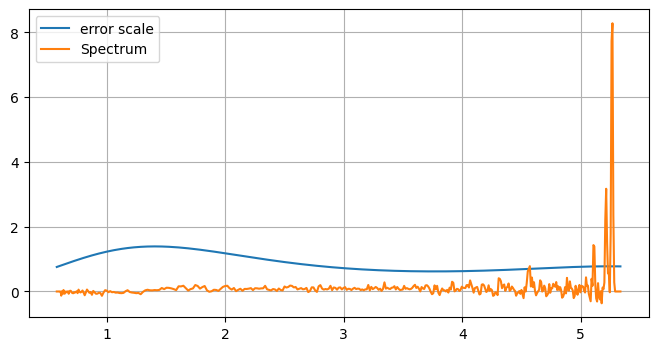

In [36]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(sp_scale['wave'], sp_scale['escale'], label='error scale')
ax.plot(sp_scale['wave'], sp_scale['flux'], label='Spectrum')
ax.legend()
ax.grid()

201it [00:04, 42.04it/s]
34it [00:00, 38.49it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# rxj2129-prism-2767_11027.spec.fits
# z = 9.50984
# Tue Feb  7 16:08:38 2023
             line Hb      276.5 ±     34.1
             line Hg      219.2 ±     28.1
             line Hd      124.7 ±     26.9
             line H8       -1.1 ±     24.0
             line H9       50.9 ±     23.6
            line H10       25.2 ±     23.5
            line H11        6.2 ±     24.1
            line H12      -22.4 ±     22.6
     line NeIII-3968       68.2 ±     29.1
      line OIII-4959      550.4 ±     30.2
      line OIII-5007     1570.0 ±     41.0
      line OIII-4363       77.6 ±     29.0
            line OII      106.9 ±     23.6
      line HeII-4687        1.3 ±     27.7
     line NeIII-3867      103.5 ±     24.2
      line HeII-1640      -99.6 ±    142.7
       line CIV-1549      557.1 ±    146.7
      line CIII-1908      333.8 ±    106.1
      line OIII-1663      544.3 ±    145.0
      line NIII-1750       47.1 ±    125.8
            line Ly

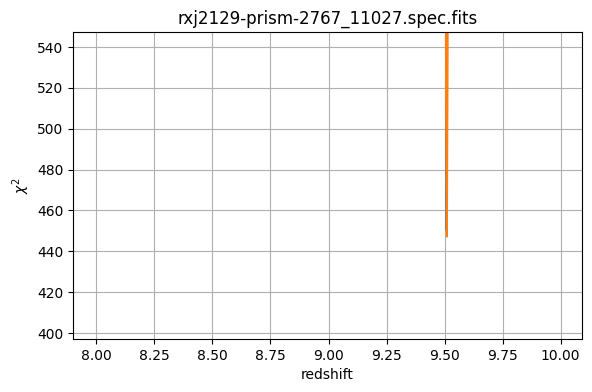

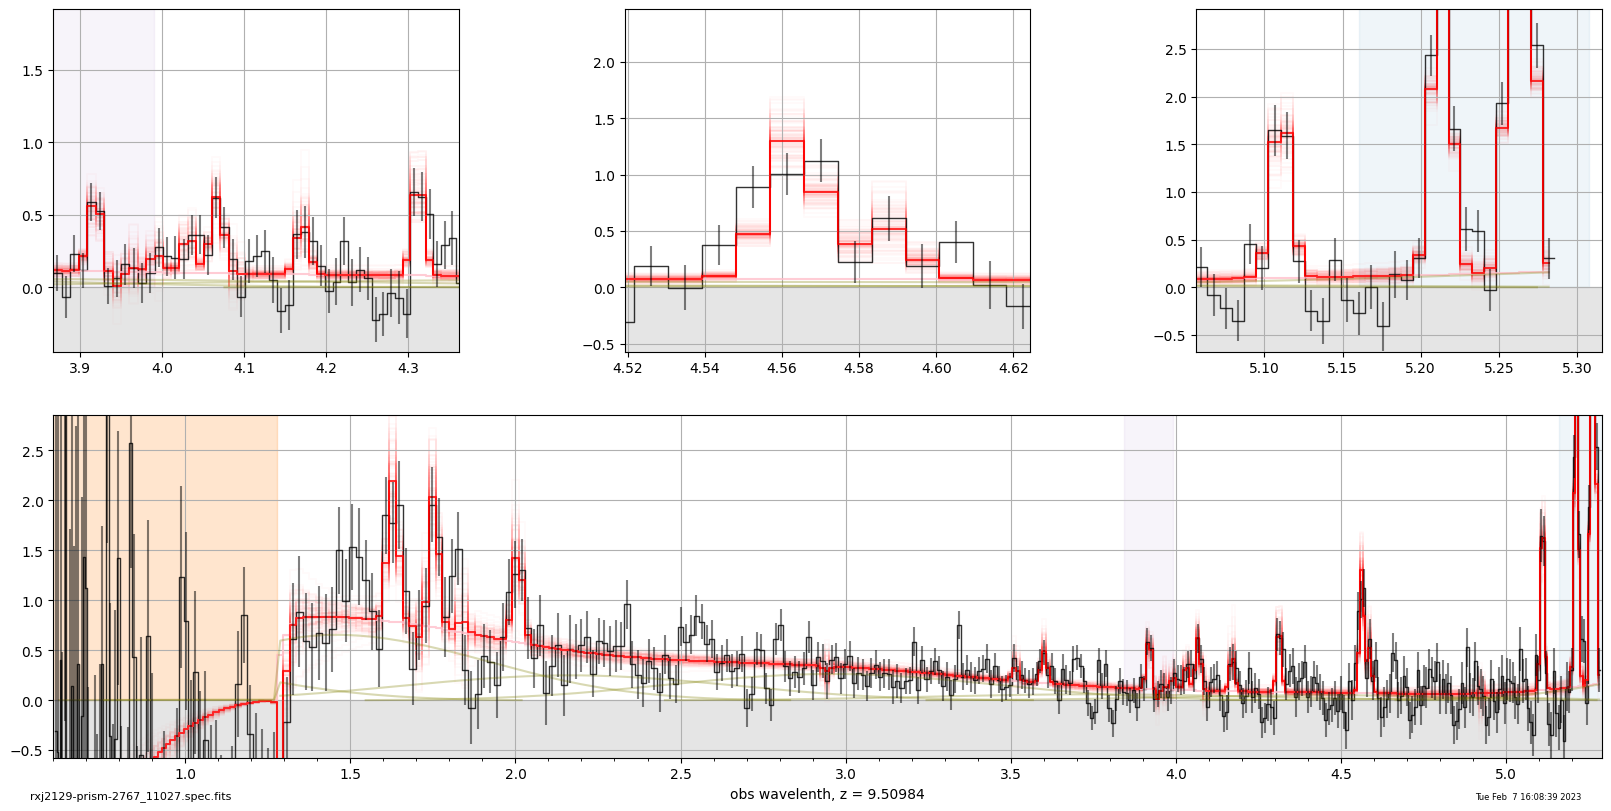

In [37]:
# Fit redshift again with scaled uncertainties

spectrum.FFTSMOOTH = False

fig, sp, data = spectrum.fit_redshift(file=f'{output_root}.spec.fits',
                          z0=[8.,10], 
                          zstep=[0.001,0.0003],
                          eazy_templates=None,
                          nspline=9,
                          scale_disp=1.3,
                          vel_width=50.,
                          Rline=2000,
                          is_prism=True,
                          use_full_dispersion=False,
                          ranges=[(3680, 4150), (4300, 4400), (4861-50, 5008+50)],
                         )

In [38]:
# Stop the notebook if "Run All"
break

SyntaxError: 'break' outside loop (4272937315.py, line 2)

# Process all groups

In [ ]:
groups = pipeline.exposure_groups()
groups

for mode in groups:
    if ('02767' in mode): # & (not os.path.exists(f'{mode}.slits.yaml')):
        # Run the pipeline to define slits, etc., but don't do extractions yet.  
        pipe = pipeline.NirspecPipeline(mode=mode)
        pipe.full_pipeline(run_extractions=False, initialize_bkg=False)
    else:
        print(f'Skip {mode}')

In [ ]:
import glob
import yaml
import grizli.utils

files = glob.glob('*2767*slits.yaml')
files.sort()

all_targets = []
skip = []
for file in files:
    with open(file) as fp:
        slits = yaml.load(fp, Loader=yaml.Loader)
        for k in slits:
            all_targets.append(k)

un = grizli.utils.Unique(all_targets)
targets = un.values
print(len(targets))
#targets

In [ ]:
from importlib import reload
from msaexp import pipeline
reload(pipeline)
print(pipeline.__file__)


gratings = {}
for mode in groups:
    if os.path.exists(f'{mode}.slits.yaml') & ('02767' in mode):
        # Run the pipeline to define slits, etc., but don't do extractions yet.  
        obj = pipeline.NirspecPipeline(mode=mode)
        obj.full_pipeline(run_extractions=False, targets=targets)
        
        if obj.grating not in gratings:
            gratings[obj.grating] = []
        
        gratings[obj.grating].append(obj)